# Part 0: Imports and pip installs
Run the cells below before you do anything else!

In [9]:
# Imports and pip installs
#### RUN THIS CELL FIRST ####

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

# Part 0: Problem Setup

In lecture, we learned...

To develop some intuition for how this works, we'll translate the mean-field formulae from lecture into python code and use it to explore manifold capacity in a few simple settings. Later on, we'll use these tools to analyze the representations learned by neural networks trained to perform image classification.

We consider a collection of manifolds $\{M_\mu\}_{\mu=1}^P$ embedded in $\mathbb{R}^N$, each of which is represented by a point cloud $M^\mu = \{\mathbf{x}^\mu_i\}_{i=1}^{n_\mu}$. Each manifold can be viewed as a compact subset of a $D$-dimensional affine subspace of $\mathbb{R}^N$ with $D < N$, and as such we can represent a point on a manifold in terms of an orthonormal basis for this subspace:

$$\mathbf{x}^\mu = \sum_{i=1}^{D+1}s_i^\mu\mathbf{u}_i = \mathbf{x}_0^\mu + \sum_{i=1}^{D}s_i^\mu\mathbf{u}_i$$

This setup is visualized in the picture below:

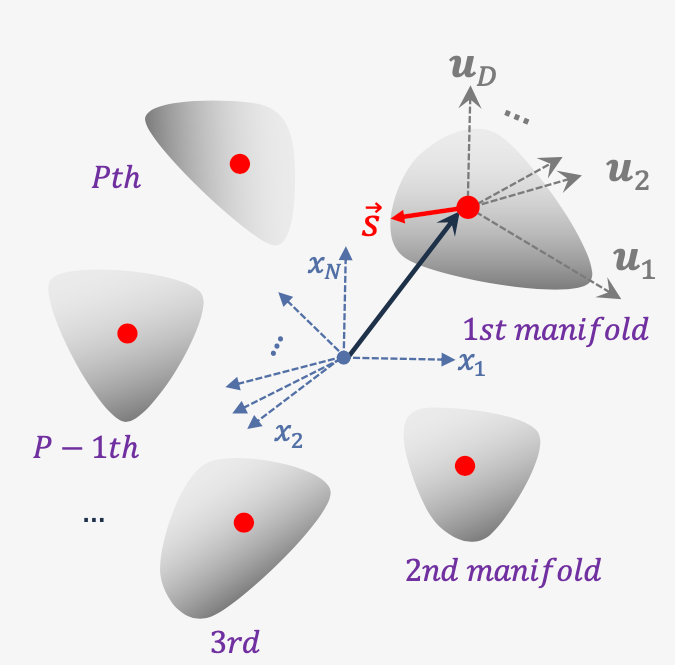

We use the notation $\vec{S} = (S_1,S_2,\ldots,S_{D+1}) \in \mathbb{R}^{D+1}$ to denote a point on a manifold in its $D+1$-dimensional basis, and $\mathcal{S} = \{\vec{S}_1,\vec{S}_2,\ldots,\vec{S}_n\}$ for the set of points associated to a manifold. Note that we need $D+1$ coordinates to describe $D$-dimensional subspace because it is not generally centered at the origin.

Given a set of manifolds $\{M_\mu\}$, we're interested in computing the following quantities for each:

1. **Manifold Capacity** $\alpha_M$: the maximum number of manifolds per neuron ($P/N$) that can be linearly separated in $\mathbb{R}^N$.
2. **Manifold Dimension** $D_M$: The dimension of the affine subspace containing the manifold.
3. **Manifold Radius** $R_M$: The "size" of the manifold in the ambient space.

In general these will be different for each $M$, since they may have different intrinsic dimensions/radii that inform how many we can efficiently pack into $\mathbb{R}^N$. In the first part of this tutorial we'll write some functions implementing the mean-field computation of $\alpha_M$, $D_M$, and $R_M$ given a collection of manifolds represented as point clouds. Later on, we'll use these tools to analyze the representations learned by neural networks and explore a capacity-inspired loss function for self-supervised representation learning. The theoretical underpinning is described in detail in [Classification and Geometry of General Perceptual Manifolds](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.031003), while the neural network experiments closely follow the analyses in [Separability and geometry of object manifolds in deep neural networks](https://www.nature.com/articles/s41467-020-14578-5) and [Learning Efficient Coding of Natural Images with Maximum Manifold Capacity Representations](https://arxiv.org/abs/2303.03307)

# Part I: Computing Manifold Capacity

Our collection of manifolds comes to us as a set of point clouds $\{X_1, \ldots, X_n\}$ where $X_i \in \mathbb{R}^{N \times P_i}$ ($P_i =$ number of points in manifold $i$). The first thing we'll implement is some basic **preprocessing** of each point cloud, which will make the capacity calculations a little easier. This consists of two steps:
1. Center *all* the manifolds about their mean in $\mathbb{R^N}$: just like you would center your data before training a neural network.
2. For each manifold, compute a $D+1$-dimensional basis for the affine subspace it lives in, and express points on the manifold in this basis (i.e. the $\vec{S}$ notation used above, as opposed to the $\mathbf{x}$ notation specifying a point on the manifold in the ambient space $\mathbb{R}^N$)

For the manifold bases, we will follow the convention of the original capacity paper and set the $D+1$-th basis vector to be the manifold's center $\mathbf{c}$ (i.e. the mean of the point cloud for the manifold). We'll then express the remaining $1,\ldots,D$ orthonormal basis vectors relative to this center. In other words, the coordinates for the center $\mathbf{c}$ will be $\vec{C} = (0,0,\ldots,0,1)$, while the coordinates for any point $\vec{S}$ will be $\vec{S} = (S_1,S_2,\ldots,S_D,1)$. 

As a warmup, let's start by normalizing our data:

In [2]:
def center_manifolds(X):
    """
    Preprocess the set of manifolds by centering all the points about the origin, then center and normalize
    the points of each manifold w.r.t to its center location/norm.
    
    Args:
        X: list[np.ndarray]: list of point clouds, each a numpy array of shape (N, P_i) where N is the
        dimensionality of the ambient space and P_i is the number of points in the i-th manifold.
        
    Returns:
        list[np.ndarray]: Preprocessed manifolds
    """
    # Compute the mean across all manifolds
    X_global_mean = np.mean(np.concatenate(X, axis=1), axis=1, keepdims=True)

    # center all manifolds about the global mean
    X_centered = [x - X_global_mean for x in X]
    
    # Compute centers (means) for each manifold and center/normalize the points of each manifold around its center
    manifold_means = [np.mean(x, axis=1, keepdims=True) for x in X_centered]
    manifold_mean_norms = [np.linalg.norm(m) for m in manifold_means]
    X_normalized = [(x - m) / norm for x, m, norm in zip(X_centered, manifold_means, manifold_mean_norms)]
    
    return X_normalized

Next, we compute our orthonormal bases. The coordinates of each point cloud should now be centered/normalized with respect to its mean position, so we just need to find a spanning set. There are two relevant cases for each point cloud $X_i \in \mathbb{R}^{N\times P_i}$:
1. $P_i \geq N$: there are more points than ambient dimensions, in which case the standard basis in $\mathbb{R}^N$ will suffice.
2. $P_i N$: there are fewer points than ambient dimensions, in which case our point cloud vectors span an at-most $P_i$-dimensional subspace of $\mathbb{R}^N$. We want to compute an orthonormal basis $(\mathbf{e}_1,\ldots,\mathbf{e}_D)$ for this space and express the points in $X_i$ in those coordinates. To do this, we will use the well-known [**QR decomposition**](https://en.wikipedia.org/wiki/QR_decomposition). Given a matrix $A \in \mathbb{R}^{m \times n},$ with $m \geq n$, the (reduced) QR decomposition expresses it as $$ A = QR, $$ where $Q$ is an $m \times n$ matrix with orthonormal columns, and $R$ is an upper triangular $n \times n$ matrix. This decomposition is essentially the [Gram-Schmidt orthonormalization](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) of the columns of $A$. Matrix decompositions like this might stir up bad memories from your college linear algebra class, but fear not! This is as much as you need to know. We'll use `np.linalg.qr` to do it for us anyway

In [3]:
def compute_manifold_bases(X):
    """
    Compute an orthonormal basis for each manifold using QR decomposition. Express points on each manifold in this basis, and add 
    an additional dimension for the center of the manifold. Each point should have coordinates of the form (S_1, S_2, ..., S_D, 1) 
    where D is the dimension of the manifold, and the last coordinate is always 1 (for the center).

    Args:
        X: list[np.ndarray]: list of point clouds, each a numpy array of shape (N, P_i). These should be the preprocessed manifold data.

    Returns:
        list[np.ndarray]: list of point clouds in their new orthonormal bases.
    """
    X_new_basis = []
    for x in X:
        # Get dimensions/number of points in ambient space
        N, P_i = x.shape
        if N > P_i:
            # Perform QR decomposition
            Q, R = np.linalg.qr(x,mode='reduced') # Q has shape 
            x = np.matmul(Q.T, x)
        # add the center coordinate (1) as an aditional dimension for each point
        N, new_dim = x.shape
        x = np.concatenate((x, np.ones((1, new_dim))), axis=0)
        # record the coordinates in the new basis
        X_new_basis.append(x)
    return X_new_basis

## The theory section...

Now we're ready to do some capacity calculations! As discussed in lecture, we can compute these quantities using the mean field theory for manifold capacity introduced in [this paper](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.031003). Capacity generally depends on the desired sepration margin $\kappa$ between manifolds, though we usually only consider the zero-margin capacity $\kappa = 0$ (i.e. a dichotomy of the manifolds is "just barely separable"). Despite this, we will implement our code for the general case $\kappa \geq 0$.

The key result from mean field theory is the following expression for the manifold capacity:

$$\alpha_M^{-1} = \langle F(\vec{T}) \rangle_{\vec{T}}$$

where the average is performed over random $D+1$-dimensional vectors $\vec{T} \sim \mathcal{N}(\mathbf{0}_{D+1},\mathbf{I}_{D+1})$, and

$$\begin{equation}F(\vec{T}) = \min_{\vec{V}}\{ ||\vec{V} - \vec{T}||^2 \, | \, \vec{V}\cdot\vec{S} - \kappa \geq 0, \; \forall \vec{S} \in \mathcal{S}\}.\end{equation}$$

Recall that $\mathcal{S}$ simply denotes the points on the manifold in terms of their $D+1$-dimensional coordinates.

This is a bit tricky to compute given the constraint on $\vec{V}$. It helps to think of the constraint in terms of the point $\vec{S} \in \mathcal{S}$ with *minimal* projection onto $\vec{V}$: if the constraint is satisfied for this $\vec{S}$, it is satisfied for all others. We thus define $$g_\mathcal{S}(\vec{V}) = \min_{\vec{S}}\{\vec{V}\cdot \vec{S} \,| \,\vec{S} \in \mathcal{S}\}$$ and rewrite our objective as

$$F(\vec{T}) = \min_{\vec{V}}\{||\vec{V} - \vec{T} ||^2 \, | \, g_\mathcal{S}(\vec{V}) - \kappa \geq 0\}.$$

Expressing it this way puts it in the [standard form](https://en.wikipedia.org/wiki/Optimization_problem#Continuous_optimization_problem) for **constrained optimization** -- a very well-studied field! The standard form for an optimization problem is:

$$
\begin{align*}
\text{min}&\text{imize } f(\mathbf{x}) \\
\text{sub}&\text{ject to } \\
&g_i(\mathbf{x}) \leq 0 \\
&h_j(\mathbf{x}) = 0
\end{align*}
$$

where $i=1,\ldots,m$ and $j=1,\ldots,\ell$ enumerate the constraint functions. In our case, we have

$$
\begin{align*}
f(\vec{V}) &= ||\vec{V} - \vec{T}||^2 \\
g(\vec{V}) &= -g_\mathcal{S}(\vec{V}) + \kappa
\end{align*}
$$

There's just one constraint -- this makes things fairly straightforward. Before we discuss solving the optimization problem we note there are two distinct cases for $F(\mathcal{T})$, one of which leads to an easy solution:

1. $\vec{T} \cdot \vec{S} - \kappa \geq 0 \; \forall \vec{S} \in \mathcal{S}$ -- in this case $\vec{V} = \vec{T}$ is a valid and optimal solution! We can check for this case by checking $\min\{\vec{T}\cdot\vec{S} \,| \, \vec{S} \in \mathcal{S}\} - \kappa \geq 0$.
2. The opposite of the above, i.e. $\vec{T} \cdot \vec{S} - \kappa < 0$ for some $\vec{S}$. In this case, we'll actually need to solve the optimization problem.

Our goal for the next coding portion is to write a routine for computing $F(\vec{T})$ so we can take an average over $\vec{T}$. We'll make use of the [`cvxopt`](https://cvxopt.org/) python package to solve the optimization problems for us, so most of the work is just setting things up correctly and translating the math above into python code.

### The KKT conditions for constrained optimization
As discussed in the [capacity paper](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.031003), the [Karush-Kuhn-Tucker (KKT) conditions](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions) are a helpful way to characterize the solution $\vec{V}^\ast$ to the optimization problem. In the standard form notation above, our optimization problem is equivalent to finding a saddle point of the following [Lagrangian function](https://en.wikipedia.org/wiki/Lagrange_multiplier):

$$
\mathcal{L}(\mathbf{x},\lambda) = f(\mathbf{x}) + \lambda g(\mathbf{x})
$$

where we are considering the simple case where there is just one inequality constraint $g(\mathbf{x})$ (i.e. our problem). The KKT conditions state that the solution $(\mathbf{x}^\ast,\lambda)$ satisfies the following conditions:

$$
\begin{align*}
&\mathbf{0} \in \partial f(\mathbf{x}^\ast) + \lambda\partial g(\mathbf{x^\ast}) \\
&g(\mathbf{x}^\ast) \leq 0 \\
&\lambda \geq 0 \\
&\lambda g(\mathbf{x}^\ast) = 0
\end{align*}
$$
where $\partial$ denotes the [subgradient](https://en.wikipedia.org/wiki/Subderivative), which for well-behaved functions we can just think of as the gradient (this is glossing over many details - apologies to the mathematically-minded among you!). 

Let's evaluate these conditions for our problem and see what they tell us! We first replace our original function $||\vec{V}-\vec{T}||^2$ with $\frac{1}{2}||\vec{V}||^2 - \vec{V}\cdot\vec{T}$, since it is simpler and has the same optimum (**exercise**: why is this?). The subgradients of $f$ and $g$ are:

$$
\begin{align*}
\partial f &= \nabla f = \vec{V} - \vec{T} \\
\partial g &= -\partial g_\mathcal{S}(\vec{V}) \equiv -\tilde{S}(\vec{T})
\end{align*}
$$

where we denote $\partial g_\mathcal{S}$ as $\tilde{S}(\vec{T})$. The KKT conditions for the optimum $(\vec{V}^\ast, \lambda)$ are thus

$$
\begin{align*}
\vec{V}^\ast - \vec{T} - \lambda\tilde{S}(\vec{T}) &= \vec{0} \\
g_\mathcal{S}(\vec{V}^\ast) - \kappa &\geq 0 \\
\lambda &\geq 0 \\
\lambda[g_\mathcal{S}(\vec{V}) - \kappa] &= 0
\end{align*}
$$



This might just seem like a lot of algebraic gymnastics, but there's insight to be had here! We make the following observations:
1. The first KKT condition means we can express $$ \vec{V}^\ast = \vec{T} + \lambda\tilde{S}(\vec{T}),$$ which, plugging into the expression for $F(\vec{T})$ above, allows us to write $$ F(\vec{T}) = ||\lambda\tilde{S}(\vec{T})||^2 $$
2. The fourth condition implies that if $g_\mathcal{S}(\vec{V}^\ast) - \kappa > 0$ then $\lambda = 0$, which by the first condition implies $\vec{V} = \vec{T}$ and we are in the trivial solution. 
3. If we are not in the trivial case, we can derive a self-consistent equation for $\lambda$ (the details are beyond the scope of this tutorial): $$ \lambda = \frac{\max(-\vec{T}\cdot \tilde{S}(\vec{T}) + \kappa, 0)}{||\tilde{S}(\vec{T})||^2} $$
4. When $g_\mathcal{S}$ is differentiable, the subgradient is equal to the gradient and is thus $$ \tilde{S}(\vec{T}) = \argmin_{\vec{S} \in \mathcal{S}} \vec{V}\cdot\vec{S}.$$ (exercise: convince yourself of this fact). When it is not differentiable, the subgradient is not unique, but $\tilde{S}(\vec{T})$ is uniquely determined as the subgradient which obeys the KKT conditions. In this case, $\tilde{S}$ may not be a member of $\mathcal{S}$ but **does** lie in its convex hull. **Importantly, in both cases $\tilde{S}$ is either a member of $\mathcal{S}$ or in its convex hull**, which as mentioned above we consider roughly equivalent to the manifold. We thus refer to them as **anchor points** for the manifold.

### Putting it all together
At this stage we may be in danger of losing the forest for the trees, but don't worry -- this all translates into a practical method for computing $F(\vec{T})$! Here's the general algorithm we'll implement below:

**Given:** Manifold point cloud $\mathcal{S} = \{S_1,\ldots,S_{P_i}\}$ in its $D+1$-dimensional basis; randomly sampled $\vec{T} \sim \mathcal{N}(\mathbf{0}_{D+1},\mathbf{I}_{D+1})$
* If $\min\{\vec{T} \cdot \vec{S} - \kappa \; | \; \vec{S} \in \mathcal{S}\} \geq 0$:
    * $\vec{V} = \vec{T}$ is the minimizer for Eq. (1) above.
    * $\tilde{S}(\vec{T}) = \argmin_{\vec{S} \in \mathcal{S}}\vec{V}\cdot \vec{S}$
* Otherwise:
    * Use your favorite optimizer to find the minimizer $\vec{V}^\ast$ and the associated Lagrange multiplier $\lambda^\ast \equiv \alpha$
    * Compute $\tilde{S}(\vec{T}) = (\vec{V}^\ast - \vec{T})/\alpha$
    * Compute $\lambda = \max(-\vec{T}\cdot\tilde{S}(\vec{T}) + \kappa,0)/||\tilde{S}(\vec{T})||^2$
    * Compute $F(\vec{T}) = \lambda^2||\tilde{S}(\vec{T})||^2$

Now we can put all of this into code! Don't worry if you didn't follow everything -- some details are missing, but you can find them all in the original capacity paper. The bullets above summarize what you'll need to code up

**Note:** You might be wondering why we don't just compute $F(\vec{T}) = ||\vec{V}^\ast - \vec{T}||^2$ in case 2 above. We'll end up needing $\tilde{S}(\vec{T})$ for the $R_M$ and $D_M$ calculations -- more on this later.

The manifold capacity ($\alpha_M$), radius ($R_M$), and dimension ($D_M$) all depend on computing average quantities involving $\vec{T}$ and $\tilde{S}(\vec{T})$ over an ensemble of randomly sampled $\vec{T}$. We thus factorize our code as follows:

Given a collection of sampled $\vec{T}_i \sim \mathcal{N}(\mathbf{0}_{D+1},\mathbf{I}_{D+1})$, where $i = 1,\ldots,n_\text{samples}$:
1. Compute the anchor vectors $\tilde{S}(\vec{T}_i)$, which we do by way of solving $\min_{\vec{V}}\{||\vec{V} - \vec{T}_i ||^2 \, | \, g_\mathcal{S}(\vec{V}) - \kappa \geq 0\}$ and using the KKT relations above
2. Compute $F(\vec{T})$ as above
3. Compute $\alpha_M^{-1} = \langle F(\vec{T}) \rangle_{\vec{T}} = \frac{1}{n_\text{samples}}\sum_{i=1}^{n_\text{samples}}F(\vec{T}_i)$

First, let's implement the anchor vector calculations, i.e. solving our optimization problem

In [ ]:
def prepare_calculations(S, kappa, num_t_samples=300):
    """
    Prepare for the capacity/dimension/radius calculations by sample num_t_samples random vectors T and computing the anchor points for each
    
    Args:
        S: np.ndarray: The point cloud representing the manifold in its basis coordinates, shape (D+1,P_i).
        kappa: float: the manifold capacity separation margin.
        num_t_samples: int: the number of random vectors T to sample; 300 is a reasonable default
    """
    
    D1, m = S.shape # D1 = D+1, m = number of points in the manifold
    
    # Sample num_t_samples random vectors T of dimension D1 from a standard normal distribution
    T_samples = np.random.normal(size=(D1, num_t_samples))

    # compute the anchor points for each T sample
    S_tildes = compute_anchor_points(S,T_samples,kappa) # implement this function below

    return S_tildes, T_samples

def compute_anchor_points(S, T_samples, kappa):
    """
    For each sampled vector in T, compute the anchor point S_tilde. This involves solving min_V (||V - T||^2 | V.s - kappa >= 0 for all s in S) for each t in T.
    
    Args:
        S: np.ndarray: (D+1, P_i) -- The point cloud representing the manifold in its basis coordinates, shape (D+1,P_i).
        T_samples: np.ndarray: (D+1, N_T) -- a collection of num_t_samples vectors in R^D+1, sampled from a standard normal distribution.
        kappa: the manifold capacity separation margin.

    Returns:
        S_tildes: np.ndarray: (D+1, num_t_samples) -- The anchor points for each sampled vector in T_samples
    """

    num_t_samples = T_samples.shape[1]  # number of random T samples

    # For each T, compute its minimum projection onto the points in S -- this will help us determine if there is a trivial solution V = T
    projections, S_min_projections = min_projection(T_samples, S) # implement this function below

    # for each random T, compute the anchor point s_tilde and collect them together
    S_tildes = [] 
    for i in range(num_t_samples):
        T = T_samples[:, i]
        
        # check if there is a V = T solution, by checking the min projection
        if projections[i] - kappa >= 0:
            Vstar = T
            s_tilde = S_min_projections[:, i]
        else:
            # compute the optimal V using a solver routine
            Vstar, alpha, min_VT2 = minimize_VminusT2(T, S, kappa)
            # use Vstar and the Lagrange multiplier alpha to compute the anchor point s_tilde
            s_tilde = (Vstar - T)/alpha
        
        S_tildes.append(s_tilde)
    
    # reshape S_tildes to be a (D+1, num_t_samples) array
    S_tildes = np.concatenate(S_tildes).T

    return S_tildes


def min_projection(T, S):
    """
    Compute the minimum projection of each vector of T onto the points in S.
    
    Args:
        T: np.ndarray: (D+1,N_T) -- a collection of N_T vectors in R^D+1
        S: np.ndarray: (D+1,P_i) -- the point cloud representing the manifold in its basis coordinates

    Returns:
        min_projections: np.ndarray: (N_T,) -- the minimum projection of each vector in T onto the points in S
        S_min_projections: np.ndarray: (D+1,N_T) -- the points in S which correspond to the minimum projections
    """
    # compute a matrix M_ij = T_i dot S_j, where T_i is the i-th vector in T and S_j is the j-th point in S
    # should  have shape (N_T, P_i)
    M = np.matmul(T.T,S)

    # compute the minimum projection for each vector in T
    min_projections = np.min(M, axis=1)

    # get the vectors in S which correspond to the minimum projections
    S_min_projections = S[:, np.argmin(M, axis=1)]

    return min_projections, S_min_projections

def minimize_VminusT2(T, S, kappa):
    """
    Minimize the function ||V - T||^2 subject to the constraint V.s - kappa >= 0 for all s in S. We use the cvxopt library to solve this constrained optimization problem.
    As discussed in the theory section, we actually minimize 0.5 * ||V - T||^2, which is equivalent to minimizing ||V - T||^2.
    We can write this as 0.5 V^2 - V.T + 0.5 T^2 and note that T^2 is just a constant, so we drop ignore that too. We just optimize 0.5V^2 - V.T

    This function is filled in for you, since learning cvxopt is beyond the scope of this tutorial. For those interested, here's a brief overview of how it works:
        cvxopt wants the problem in the form of a quadratic program:
            minimize 0.5 x^T P x + q^T x
            subject to Gx <= h
        In our case x = T and we have:
            P = I (identity matrix)
            q = -T
        Our constrant is V.s - kappa >= 0 for all s in S, which we can write as:
            matmul(S_transpose, V) - kappa >= 0 
            --> matmul(-S_transpose, V) <= -kappa
            so G = -S_transpose and h = -kappa
        
    
    Args:
        T: np.ndarray: (D+1,) -- a vector in R^D+1
        S: np.ndarray: (D+1,P_i) -- the point cloud representing the manifold in its basis coordinates
        kappa: float -- the separation margin

    Returns:
        Vstar: np.ndarray: (D+1,) -- the optimal vector V which minimizes ||V - T||^2 subject to the constraint
        alpha: float -- the Lagrange multiplier associated with the constraint
        min_VT2: float -- the minimum value of the original objective function ||V - T||^2
    """
    D1 = T.shape[0]
    m = S.shape[1] 

    # set up the quadratic program
    P = cvxopt.matrix(np.eye(D1))  # identity matrix of shape 
    q = cvxopt.matrix(-T)
    G = cvxopt.matrix(-S.T)
    h = cvxopt.matrix(-kappa * np.ones(m))

    # solve the quadratic program
    sol = cvxopt.solvers.qp(P, q, G, h)

    # retrieve the outputs we want: Vstar and the Lagrange multiplier alpha
    Vstar = np.array(sol['x']) # optimal V
    alpha = np.array(sol['z']) # Lagrange multiplier
    min_VT2 = np.sum((Vstar-T)**2) # the minimum value of the original objective function ||V-T||^2

    return Vstar, np.sum(alpha), min_VT2

Now that we have a function to compute the anchor points $\tilde{S}(\vec{T}_i)$, let's write one to compute $F(\vec{T}_i)$ over a set of samples $\vec{T}_i$.

In [ ]:
def compute_F(S_tildes, T_samples, kappa):
    """
    Compute the function F(T) = ||lambda * S_tilde(T)||^2 for each T in T_samples

    Args:
        S_tildes: np.ndarray: (D+1, num_t_samples) -- the anchor points for each sampled vector in T_samples
        T_samples: np.ndarray: (D+1, num_t_samples) -- a collection of num_t_samples vectors in R^D+1, sampled from a standard normal distribution.
        kappa: float -- the manifold capacity separation margin
    """
    # Compute the norms ||s_tilde||^2 and lambda, as described in the theory section
    S_tilde_normSquared = np.sum(S_tildes**2, axis=0)  # ||s_tilde||^2 for each s_tilde; shape (num_t_samples,)
    lam = np.maximum(np.sum(-T_samples * S_tildes, axis=0) + kappa, 0) / S_tilde_normSquared # shape (num_t_samples,)

    # use lambda and S_tilde_normSquared to compute F(T) for each T
    FT = (lam**2) * S_tilde_normSquared  # F(T) for each T; shape (num_t_samples,)

    return FT

Now we can finally implement the manifold capacity computation! We've done all the hard work above, so this part should be easy

In [ ]:
def compute_manifold_capacity(S_tildes, T_samples, kappa):
    """
    Compute manifold capacity 1/alpha_M = mean(F(T))

    Args:
        S_tildes: np.ndarray: (D+1, num_t_samples) -- the anchor points for each sampled vector in T_samples
        T_samples: np.ndarray: (D+1, num_t_samples) -- a collection of num_t_samples vectors in R^D+1, sampled from a standard normal distribution.
        kappa: float -- the manifold capacity separation margin
    """
    FT = compute_F(S_tildes, T_samples, kappa)  # compute the F(T)s 
    
    alpha_M = 1.0 / np.mean(FT) # compute manifold capacity; note that the formulas above are for the the inverse of the capacity!

    return alpha_M

### Radius and Dimension calculations
Now that we have all the tools in place to compute anchor points, we can also compute manifold radius and dimension. These quantities are derived from the statistics of the anchor points $\tilde{S}(\vec{T}_i)$ induced by the random vectors $\vec{T}_i$. 

1. **Manifold radius** $R_M$ is defined as $$ R_M^2 = \langle ||\delta \tilde{S}(\vec{T})||^2 \rangle_{\vec{T}}, \quad \delta\tilde{S}(\vec{T}) = \frac{\tilde{S}(\vec{T}) - S_0}{||S_0||}$$ where $S_0$ is the manifold center